In [4]:
%matplotlib inline
import matplotlib.pyplot as pl
import pystan
from pystan import StanModel

In [5]:
### Generate data from a Gaussian Process Simulator using PyStan:

# Simulator model:

# first model is a univariate model:

GP_simulator_model_1 = """

data {
  int<lower=1> N;
  real x[N];
}

transformed data {
  vector[N] mu;
  cov_matrix[N] Sigma;
  for (i in 1:N)
    mu[i] <- 0;
  for (i in 1:N)
    for (j in 1:N) {
      Sigma[i, j] <- exp(-pow(x[i] - x[j], 2)) + if_else(i==j, 0.1, 0.0);
      // The covariance matrix Sigma is not being computed efficiently here; 
      // see Section Section 15.3 of Stan Manual for a better approach.
    }      
}

parameters {
  vector[N] y;
}

model {
  y ~ multi_normal(mu, Sigma);
}

"""

# Compiled Stan Model
sm_sim_univariate = StanModel(model_code=GP_simulator_model_1)

In [8]:
# Second model is a multivariate model:

GP_simulator_model_2 = """

data {
  int<lower=1> D;
  int<lower=1> N;
  vector[D] x[N];
}

transformed data {
  vector[N] mu;
  cov_matrix[N] Sigma;
  for (i in 1:N)
    mu[i] <- 0;
  for (i in 1:N)
    for (j in 1:N) {
      Sigma[i, j] <- exp(-dot_self(x[i] - x[j])) + if_else(i==j, 0.1, 0.0);
      // The squared Euclidean distance calculation is done using the 
      // dot_self function, which returns the dot product of its argument 
      // with itself, here x[i] - x[j].
    }      
}

parameters {
  vector[N] y;
}

model {
  y ~ multi_normal(mu, Sigma);
}

"""

# Compiled Stan Model
sm_sim_multivariate = StanModel(model_code=GP_simulator_model_2)

In [11]:
# first model is a univariate model:

GP_simulator_model_3 = """

data {
  int<lower=1> N;
  real x[N];
}

transformed data {
  vector[N] mu;
  cov_matrix[N] Sigma;
  matrix[N, N] L;
  for (i in 1:N)
    mu[i] <- 0;
  for (i in 1:N)
    for (j in 1:N) {
      Sigma[i, j] <- exp(-pow(x[i] - x[j], 2)) + if_else(i==j, 0.1, 0.0);
      // The covariance matrix Sigma is not being computed efficiently here; 
      // see Section Section 15.3 of Stan Manual for a better approach.
    }  
    L <- cholesky_decompose(Sigma);
}

parameters {
  vector[N] z;
}

model {
  z ~ normal(0, 1);
}

generated quantities {
  vector[N] y;
  y <- mu + L * z;
}

"""

# Compiled Stan Model
sm_sim_univariate_with_Cholesky = StanModel(model_code=GP_simulator_model_3)

[ 0.11316734  0.55114214  0.64465931  4.5488851   4.77087183  6.61349852
  7.49871128  8.1850056   8.82504897  9.24671617]
[ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
[-0.00733836  0.30079487  0.56474016 -0.95689829 -1.13820031  0.67006113
  0.87015279  1.00613523  0.45603368  0.34948343]


<Container object of 3 artists>

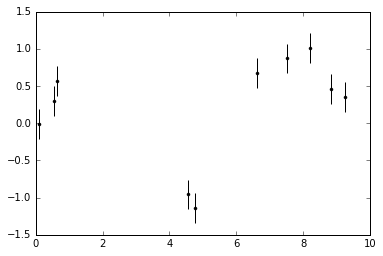

In [15]:
import numpy as np

# Tutorial for DFM Goerge code. 
# Generate some fake noisy data.
N = 10
x = N * np.sort(np.random.rand(N))
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))

print(x)
print(yerr)
print(y)

pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)



In [16]:
GP_test_model = """

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
  }

transformed data {
  vector[N] mu;
  for (i in 1:N) 
    mu[i] <- 0;
  }

parameters {
  real<lower=0> eta_sq;
  real<lower=0> inv_rho_sq;
  real<lower=0> sigma_sq;
}

transformed parameters {
  real<lower=0> rho_sq;
  rho_sq <- inv(inv_rho_sq);
} 

model {
  matrix[N, N] Sigma;
  // off-diagonal elements
  for (i in 1:(N-1)) {
    for (j in (i+1):N) {
      Sigma[i, j] <- eta_sq * exp(-rho_sq * pow(x[i] - x[j],2));
      Sigma[j, i] <- Sigma[i, j];
    } 
  }
      // diagonal elements
  for (k in 1:N)
    Sigma[k, k] <- eta_sq + sigma_sq;  // + jitter

// hyperpriors: 
// Because the hyperparameters are required to be positive and expected to 
// have reasonably small values, broad half-Cauchy distribu- tions act as 
// quite vague priors which could just as well be uniform over a constrained 
// range of values.

//  eta_sq ~ cauchy(0, );
//  inv_rho_sq ~ cauchy(0, 5);
//  sigma_sq ~ cauchy(0, 5);

  eta_sq ~ gamma(1,1); // increasing alpha and beta makes variance smaller, but depends.
  inv_rho_sq ~ uniform(0, 2);
  sigma_sq ~ gamma(1, 1);


  y ~ multi_normal(mu, Sigma);
}
  
"""

# Compiled Stan Model
sm = StanModel(model_code=GP_test_model)

In [17]:
data = {'N':N, 'x':x, 'y':y}

# Could set initial value to Max Likelihood solution without radius errors
#init = [{'lnf0':0.66,'alpha':-1.82,'beta':-0.65}]

fit = sm.sampling(data=data, iter=1000, chains=5, n_jobs=-1)

#get_inits(fit)

# Return a dictionary of arrays of posterior samples
la = fit.extract(permuted=True)  
#mu = la['mu']
#Sigma = la['Sigma']

eta_sq = la['eta_sq']
inv_rho_sq = la['inv_rho_sq']
sigma_sq = la['sigma_sq']
rho_sq = la['rho_sq']

a = fit.extract(permuted=False)
print(fit)



//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
Wh

Inference for Stan model: anon_model_318d773aa8046d10b6661d1129ca999d.
5 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2500.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
eta_sq       0.59  8.2e-3   0.41   0.15   0.33   0.48   0.74   1.72 2500.0   1.01
inv_rho_sq   1.33  9.0e-3   0.45   0.39   1.01    1.4   1.72   1.96 2500.0   1.02
sigma_sq      0.1  2.6e-3   0.13 6.7e-3   0.03   0.06   0.12   0.46 2500.0   1.01
rho_sq       0.92    0.01   0.65   0.51   0.58   0.72   0.99   2.54 2500.0   1.01
lp__        -2.05    0.03   1.32  -5.44  -2.74  -1.77  -1.06  -0.37 2500.0   1.01

Samples were drawn using NUTS(diag_e) at Thu Oct 20 12:32:24 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


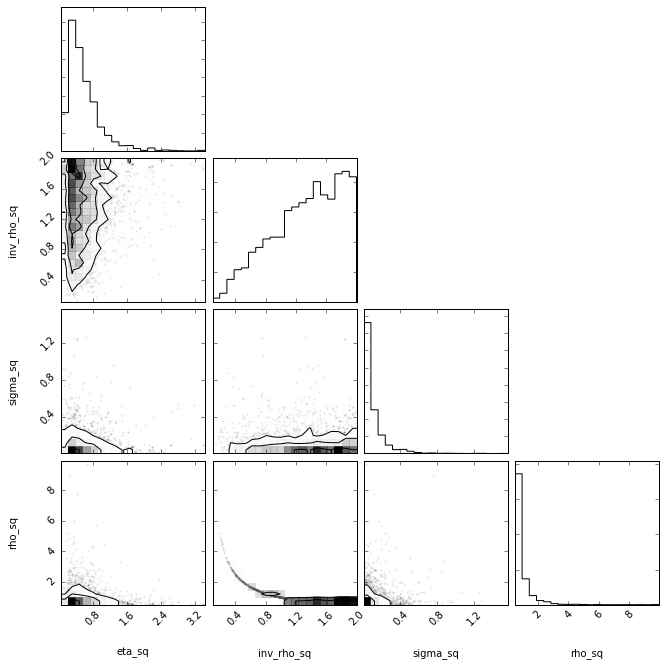

In [18]:
import corner

corner.corner(np.hstack((eta_sq.reshape(-1,1), inv_rho_sq.reshape(-1,1), sigma_sq.reshape(-1,1), rho_sq.reshape(-1,1))), labels=[r"eta_sq", r"inv_rho_sq", r"sigma_sq", r"rho_sq"]);


In [19]:
#print(sm)
print(eta_sq.shape)

(2500,)


In [20]:
### calculate the mean for the random variable y 
# tilda for each vector of hyper parameters using the formula 
# for this.  Then plot the mean and std for each t value (value you want to predict). 

In [21]:
print(fit)

Inference for Stan model: anon_model_318d773aa8046d10b6661d1129ca999d.
5 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2500.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
eta_sq       0.59  8.2e-3   0.41   0.15   0.33   0.48   0.74   1.72 2500.0   1.01
inv_rho_sq   1.33  9.0e-3   0.45   0.39   1.01    1.4   1.72   1.96 2500.0   1.02
sigma_sq      0.1  2.6e-3   0.13 6.7e-3   0.03   0.06   0.12   0.46 2500.0   1.01
rho_sq       0.92    0.01   0.65   0.51   0.58   0.72   0.99   2.54 2500.0   1.01
lp__        -2.05    0.03   1.32  -5.44  -2.74  -1.77  -1.06  -0.37 2500.0   1.01

Samples were drawn using NUTS(diag_e) at Thu Oct 20 12:32:24 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [22]:
#print(la)

In [23]:
#print(a)
#print(a.shape)

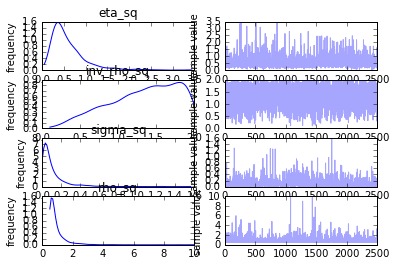

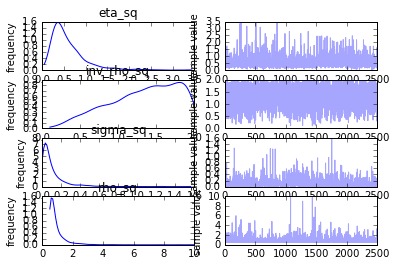

In [24]:
fit.traceplot()

In [30]:
##  Build a prediction function
import pylab as py
import pandas as pd

In [26]:
# Predictive Inference with a Gaussian Process:

GP_test_predict_model_1 = """

data {
  int<lower=1> N1;
  int<lower=1> N2;
  vector[N1] x1;
  vector[N1] y1;
  vector[N2] x2;
}

transformed data {
  int<lower=1> N;
  vector[N1+N2] x;
  vector[N1+N2] mu;
  cov_matrix[N1+N2] Sigma;
  N <- N1 + N2;
  for (n in 1:N1) 
    x[n] <- x1[n]; 
  for (n in 1:N2) 
    x[N1 + n] <- x2[n];
  for (i in 1:N) 
    mu[i] <- 0;
  for (i in 1:N)
    for (j in 1:N) {
      Sigma[i, j] <- exp(-pow(x[i] - x[j],2)) + if_else(i==j, 0.1, 0.0);
    }
}
    
parameters {
  vector[N2] y2;
}

model {
  vector[N] y;
  for (n in 1:N1) y[n] <- y1[n];
  for (n in 1:N2) y[N1 + n] <- y2[n];
  y ~ multi_normal(mu, Sigma);
}

"""

# Compiled Stan Model
sm_p = StanModel(model_code=GP_test_predict_model_1)

In [27]:
## Cholesky Factorization Speedup of above model:

GP_test_predict_model_2 = """

data {
  int<lower=1> N1;
  int<lower=1> N2;
  vector[N1] x1;
  vector[N1] y1;
  vector[N2] x2;
}

transformed data {
  int<lower=1> N;
  vector[N1+N2] x;
  vector[N1+N2] mu;
  cov_matrix[N1+N2] Sigma;
  matrix[N1+N2, N1+N2] L;
  N <- N1 + N2;
  for (n in 1:N1) 
    x[n] <- x1[n]; 
  for (n in 1:N2) 
    x[N1 + n] <- x2[n];
  for (i in 1:N) 
    mu[i] <- 0;
  for (i in 1:N)
    for (j in 1:N) {
      Sigma[i, j] <- exp(-pow(x[i] - x[j],2)) + if_else(i==j, 0.1, 0.0);
    }
  L <- cholesky_decompose(Sigma);
}
    
parameters {
  vector[N2] y2;
}

model {
  vector[N] y;
  for (n in 1:N1) y[n] <- y1[n];
  for (n in 1:N2) y[N1 + n] <- y2[n];
  y ~ multi_normal_cholesky(mu,L);  
}

"""

# Compiled Stan Model
sm_p_Cholesky_speedup = StanModel(model_code=GP_test_predict_model_2)

In [28]:
# Generate some simple fake noisy data (from DFM Goerge tutorial).
N1 = 10
N2 = 500
x1 = N * np.sort(np.random.rand(N))
yerr = 0.2 * np.ones_like(x)
y1 = np.sin(x) + yerr * np.random.randn(len(x))
x2 = np.linspace(0, 10, 500)

#data_p = {'N':N, 'N1':N1, 'N2':N2, 'x1':x, 'x2':t, 'y1':y}
data_p = {'N1':N1, 'N2':N2, 'x1':x1, 'x2':x2, 'y1':y1}



In [29]:
# syntax for initialization dictionary:
#init = [{'lnf0':0.66,'alpha':-1.82,'beta':-0.65}]

fit_p = sm_p.sampling(data=data_p, iter=10, chains=5, n_jobs=-1)

# Return a dictionary of arrays of posterior samples
la_p = fit_p.extract(permuted=True)  

y2 = la_p['y2']

a = fit_p.extract(permuted=False)

print(fit_p)

//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
//anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
Wh

Inference for Stan model: anon_model_a1380aba54fd05e2a0d4b30a9cca4cd8.
5 chains, each with iter=10; warmup=5; thin=1; 
post-warmup draws per chain=5, total post-warmup draws=25.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y2[0]     -0.1    0.09   0.44  -0.69  -0.42  -0.11   0.32   0.52   25.0   3.84
y2[1]     0.09    0.08   0.39  -0.46  -0.07  -0.01   0.39   0.72   25.0   3.29
y2[2]     0.03    0.08   0.41  -0.62  -0.17   0.08   0.39   0.81   25.0   4.37
y2[3]     0.35    0.09   0.46  -0.36   0.07   0.55   0.67   0.91   25.0   2.91
y2[4]     0.36     0.1   0.49  -0.49   0.24   0.48   0.71   0.89   25.0  22.94
y2[5]     0.44    0.15   0.76  -0.41   0.09   0.23   0.53    1.8   25.0  10.15
y2[6]     0.16    0.08   0.39  -0.43 6.4e-4   0.02   0.51   0.81   25.0   2.23
y2[7]    -0.12    0.11   0.54  -0.78  -0.67  -0.06   0.46   0.47   25.0  12.95
y2[8]      0.5    0.05   0.27   0.15   0.34   0.46   0.54   0.97   25.0   4.32
y2[9]     0.08    0.12   0.62  

0.0358937437743
[u'y2', u'lp__']
(5, 5, 501)
[[ -2.56755203e-03   1.77366694e-01   8.23148386e-01 ...,  -6.92969880e-01
    1.45817804e-01  -3.20167189e+02]
 [ -1.13441698e-01   3.87136910e-01  -1.70850217e-01 ...,  -1.20093144e+00
   -4.42357051e-01  -5.00737602e+02]
 [ -4.20955094e-01  -6.71125994e-02   7.70421412e-02 ...,  -2.72922858e-01
   -1.17398941e-01  -2.90958368e+02]
 [  3.23147080e-01  -1.46876355e-02   4.06675979e-01 ...,  -2.75641791e-01
   -3.93040754e-01  -3.65516764e+02]
 [ -6.87416970e-01  -4.58571860e-01  -6.17249230e-01 ...,   7.95433630e-01
    2.08369732e-01  -4.43777083e+02]]
Inference for Stan model: anon_model_318d773aa8046d10b6661d1129ca999d.
5 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2500.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
eta_sq       0.59  8.2e-3   0.41   0.15   0.33   0.48   0.74   1.72 2500.0   1.01
inv_rho_sq   1.33  9.0e-3   0.45   0.39   1

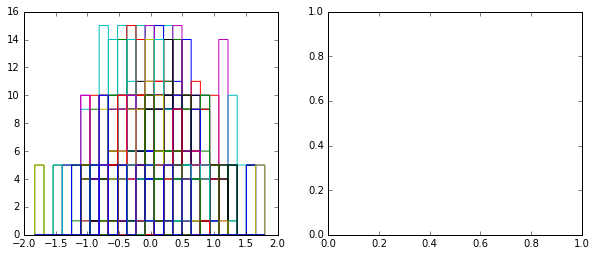

In [64]:
##### PREDICTION ####
 
# make a dataframe of parameter estimates for all chains
#params = pd.DataFrame({'eta_sq': fit.extract('eta_sq', permuted=True), 'sigma_sq': fit.extract('sigma_sq', permuted=True), 'rho_sq': fit.extract('rho_sq', permuted=True)})
#prediction_pandas_data_frame = pd.DataFrame({'mean': fit_p.extract('mean',permuted=False), 'mean': fit_p.extract('se_mean',permuted=False)})
#print(prediction_pandas_data_frame)
print(np.mean(y2))
      
trace = fit_p.extract()
print(trace.keys())

trace2 = fit_p.extract(permuted=False)
print(trace2.shape)
print(trace2[:][0])

print(fit)

pl.figure(figsize=(10,4))
pl.subplot(1,2,1);
pl.hist(trace['y2'][:], 25, histtype='step');
pl.subplot(1,2,2);

#params = pd.DataFrame.from_records(fit_p)
#params = pd.DataFrame.from_records(fit_p, index=None, exclude=None, columns=None, coerce_float=False, nrows=None)

In [ ]:
mu = 
std = 

pl.errorbar(x1, y1, yerr=yerr, fmt=".k", capsize=0)
pl.plot(t, mu, "k", lw=0.3)
#pl.fill_between(t, mu+std, mu-std, color="k", alpha=0.1, edgecolor="none")
pl.fill_between(x2, mu+std, mu-std, color="0.9", alpha=1.0, edgecolor="k", lw=0.3)
pl.xlabel("$x$")
pl.ylabel("$y$")